# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [2]:
from belashovplot import TiledPlot, FontLibraryClass
from utilities import *
from utilities.filters import Gaussian, Window
from elements.abstracts import AbstractModulator, AbstractPropagator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator, Mask
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from elements.simple import AdjustSize
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
import torch
import numpy
import pandas
from copy import deepcopy
from itertools import product
from typing import Iterable, Callable, Union
from cluster import train, confusion, execute, epochs

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8
FigureWidthHeight = (11.7, 16.5)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Определение параметров экспериметна

In [32]:
# Предпочтительные параметры
size = 9.765625E-6/2
near_N = 2048 #2004 #1336
near_length = 10.0E-3
wavelength = 500.0E-9

# Параметры когерентности
spatial_coherence_range = torch.linspace(5.0E-6, 800.0E-6, 20)
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 80

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size
cppp = int(near_N * size / length)
N = upper_integer(length*cppp / size) 

# Параметры эксперимента
slit_width = size
slit_space = 70.0E-6
distance = 200.0E-3
distance_samples = 50
distance_range = torch.linspace(0, distance, distance_samples)

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(length/pixels, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence_range[0].item(), 'м')} : {engineering(spatial_coherence_range[-1].item(), 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       2048
Количество пикселей маски:                2048
Размер оптических элементов:              10.0 мм
Размер пикселя маски:                     4.883 мкм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           5.0 мкм : 800.0 мкм
Количество усреднений:                    80


# Инициализация эксперимента

In [33]:
initial_field_filter_1 = Window(centers=(-slit_space/2, 0), sizes=(slit_width, length))
initial_field_filter_2 = Window(centers=(+slit_space/2, 0), sizes=(slit_width, length))
initial_field = initial_field_filter_1(*[torch.linspace(-length/2,+length/2,N)]*2) + initial_field_filter_2(*[torch.linspace(-length/2,+length/2,N)]*2)
initial_field = initial_field.unsqueeze(0).unsqueeze(0).to(device)

propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, border_ratio=0.5).to(device)

# Эксперимент

In [34]:
incoherence_demonstrations = []
slices_list = []
result_list = []

with torch.no_grad():
    for row, spatial_coherence in tqdm(enumerate(spatial_coherence_range), total=len(spatial_coherence_range)):
        incoherence = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
        encoder, decoder = incoherence.encoder, incoherence.decoder
        encoder, decoder = encoder.to(device), decoder.to(device) 
        incoherence_demonstrations.append(incoherence.sample()[0].cpu())

        slices = torch.zeros((distance_samples, N))
        for i, dist in enumerate(distance_range):
            propagation.distance = dist
            result = decoder.forward(propagation.forward(encoder.forward(initial_field))).abs().squeeze().cpu()[:,N//2]
            slices[i] = result
        slices_list.append(slices)
        
        propagation.distance = distance
        result = decoder.forward(propagation.forward(encoder.forward(initial_field))).abs().squeeze().cpu()
        result_list.append(result)

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [16:46<00:00, 50.35s/it]


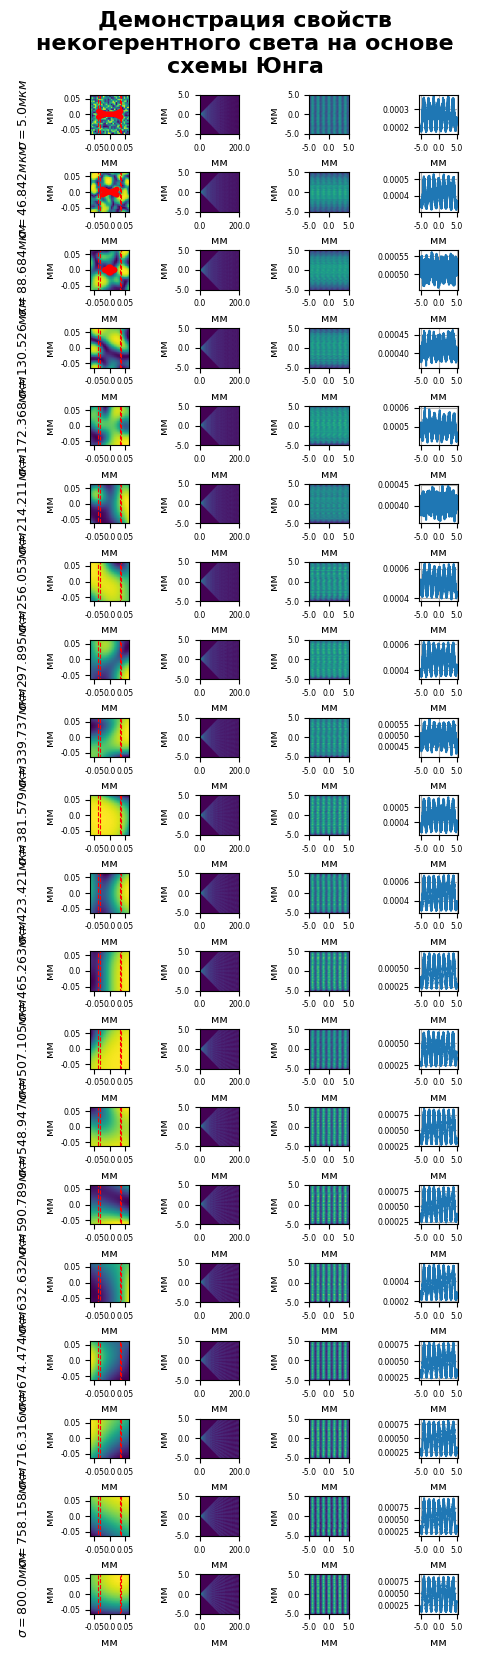

In [35]:
from matplotlib.patches import Rectangle

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title("Демонстрация свойств некогерентного света на основе схемы Юнга")

foramtter_xy, unit_xy = engineering.separatedformatter(length,'м')

scale = 0.9
p0, p1 = int(N * (length/2 - slit_space*scale) / length), int(N * (length/2 + slit_space*scale) / length)

for row, (spatial_coherence, incoherence_sample, slices, result) in enumerate(zip(spatial_coherence_range, incoherence_demonstrations, slices_list, result_list)):
    plot.description.row.left(f"$\sigma={engineering(spatial_coherence.item(),'м',space='')}$", row)
    
    axes = plot.axes.add(0,row)
    axes.imshow(incoherence_sample[p0:p1,p0:p1], aspect='auto', extent=[-slit_space*scale,+slit_space*scale]*2)
    axes.xaxis.set_major_formatter(foramtter_xy)
    axes.yaxis.set_major_formatter(foramtter_xy)
    plot.graph.label.x(unit_xy)
    plot.graph.label.y(unit_xy)
    axes.add_patch(Rectangle((-(slit_space+slit_width)/2, -length/2), slit_width, length, linestyle='--', color='red', linewidth=0.8, fill=False))
    axes.add_patch(Rectangle((+(slit_space-slit_width)/2, -length/2), slit_width, length, linestyle='--', color='red', linewidth=0.8, fill=False))
    axes.annotate(text='', xy=(-spatial_coherence/2,0), xytext=(+spatial_coherence/2,0), arrowprops=dict(arrowstyle='<->', color='red', linewidth=4.0))

    axes = plot.axes.add(1,row)
    axes.imshow(torch.log10(slices.swapdims(0,1)+0.001), aspect='auto', extent=[0,distance,-length/2,+length/2])
    axes.xaxis.set_major_formatter(foramtter_xy)
    axes.yaxis.set_major_formatter(foramtter_xy)
    plot.graph.label.x(unit_xy)
    plot.graph.label.y(unit_xy)


    axes = plot.axes.add(2,row)
    axes.imshow(result.swapdims(0,1), aspect='auto', extent=[-length/2,+length/2]*2)
    axes.xaxis.set_major_formatter(foramtter_xy)
    axes.yaxis.set_major_formatter(foramtter_xy)
    plot.graph.label.x(unit_xy)
    plot.graph.label.y(unit_xy)

    axes = plot.axes.add(3,row)
    axes.grid(True)
    axes.plot(torch.linspace(-length/2,+length/2,N), result[:,N//2])
    axes.xaxis.set_major_formatter(foramtter_xy)
    plot.graph.label.x(unit_xy)
plot.show()

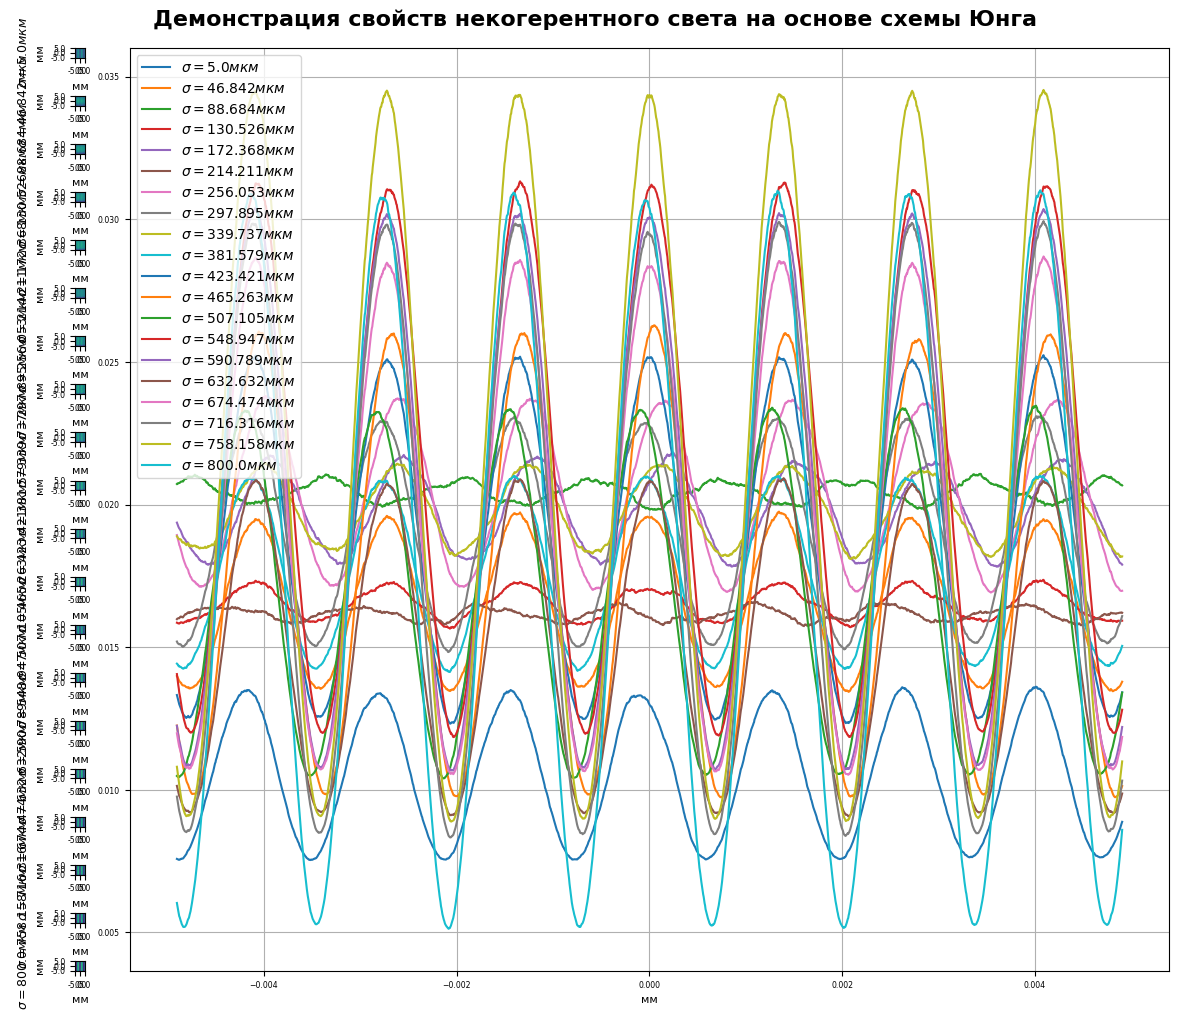

In [36]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title("Демонстрация свойств некогерентного света на основе схемы Юнга")

foramtter_xy, unit_xy = engineering.separatedformatter(length,'м')
signal_kernel = torch.ones(N//50)


main_axes = plot.axes.add((1,0), (len(spatial_coherence_range), len(spatial_coherence_range)-1))
main_axes.grid(True)
axes.xaxis.set_major_formatter(foramtter_xy)
plot.graph.label.x(unit_xy)

for row, (spatial_coherence, incoherence_sample, slices, result) in enumerate(zip(spatial_coherence_range, incoherence_demonstrations, slices_list, result_list)):
    plot.description.row.left(f"$\sigma={engineering(spatial_coherence.item(),'м',space='')}$", row)

    axes = plot.axes.add(0,row)
    axes.imshow(result.swapdims(0,1), aspect='auto', extent=[-length/2,+length/2]*2)
    axes.xaxis.set_major_formatter(foramtter_xy)
    axes.yaxis.set_major_formatter(foramtter_xy)
    plot.graph.label.x(unit_xy)
    plot.graph.label.y(unit_xy)

    signal = result[:,N//2]
    signal = torch.nn.functional.conv1d(signal.unsqueeze(0), signal_kernel.unsqueeze(0).unsqueeze(0)).squeeze()
    main_axes.plot(torch.linspace(-length/2,+length/2,N)[N//100:N//100 + N - N//50 + 1], signal, label=f"$\sigma={engineering(spatial_coherence.item(),'м')}$")
main_axes.legend()
plot.show()

In [ ]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title("Демонстрация свойств некогерентного света на основе схемы Юнга")

foramtter_xy, unit_xy = engineering.separatedformatter(length,'м')
signal_kernel = torch.ones(N//50)


visibilities = []
main_axes = plot.axes.add((1,0), (len(spatial_coherence_range), len(spatial_coherence_range)-1))
main_axes.grid(True)

for row, (spatial_coherence, incoherence_sample, slices, result) in enumerate(zip(spatial_coherence_range, incoherence_demonstrations, slices_list, result_list)):
    plot.description.row.left(f"$\sigma={engineering(spatial_coherence.item(),'м',space='')}$", row)

    axes = plot.axes.add(0,row)
    axes.imshow(result.swapdims(0,1), aspect='auto', extent=[-length/2,+length/2]*2)
    axes.xaxis.set_major_formatter(foramtter_xy)
    axes.yaxis.set_major_formatter(foramtter_xy)
    plot.graph.label.x(unit_xy)
    plot.graph.label.y(unit_xy)

    signal = result[:,N//2]
    signal = torch.nn.functional.conv1d(signal.unsqueeze(0), signal_kernel.unsqueeze(0).unsqueeze(0)).squeeze()
    visibilities.append((signal.max()-signal.min())/(signal.max()+signal.min()))

main_axes.plot(spatial_coherence_range, visibilities)
plot.show()